In [1]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg

In [2]:
def read_labels():
    apk_label_ds1_path = '../data/labels_vt_mal_2017_2020_az_2020_benign_hashed.csv'
    ds1_labels_df = pd.read_csv(apk_label_ds1_path)
    ds1_labels_df.set_index(ds1_labels_df.apk.apply(lambda x:x.upper()), inplace=True)
    ds1_labels_df.drop(labels='apk',axis=1, inplace=True)
#    ds1_labels_df.head(2)
    print("Got data: ", len(ds1_labels_df))
    return ds1_labels_df

In [76]:
def transform_app_data(fname='../data/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.csv'):
    sf_ds1_full = gl.SFrame.read_csv(fname, header=False, verbose=False)
    _=sf_ds1_full.rename({'X3':'fcount'})
    sf_ds1_full['apk']=sf_ds1_full['X1'].apply(lambda x: x.upper())
    sf_ds1_full['function'] = sf_ds1_full['X2'].apply(lambda x: x.upper())
    
    _=sf_ds1_full.remove_columns(['X1', 'X2'])
    
    print("Unique APK:", len(set(sf_ds1_full['apk'].unique())))
    print("Unique functions:", len(set(sf_ds1_full['function'].unique())))

    outname = fname.replace('data', 'binarydata').replace('.csv', '.sframe')
    sf_ds1_full.save(outname, format='binary')

transform_app_data()

('Unique APK:', 10003)
('Unique functions:', 699854)


In [2]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')

In [3]:
mw.head()

fcount,apk,function
1,3407F2E5AB21E8966BDFAF33D805DE7AC97BED3A7454C1 ...,2D6877D28225C6E0F115275774CDA94C ...
1,006373DF53793664DDD73C7A96B18794A10DE6FAAD185B ...,4B673494945E9BF470675331FC1D6B27 ...
2,238230D0B795F97E596FA7379AF0769D74ED3810976092 ...,96D7A6B3A2BEA95CA0E3B74FE3C4E7F8 ...
1,25A3382B3FAAAC9D5A14FE8DE914D47B3BC6284599FD27 ...,A6D7D5D7968AE7BDC62AD696AE7E6BD1 ...
1,4D0F5074E2A7579DBC87C0D8483EFEB3D31B24E0008BD1 ...,20E0EB29F9F144A01276B87CFC0AC2A1 ...
1,94F2FB12A21085764C85DB0E9E4B381EEDD1DC65E4F2D7 ...,F66DB25FFCDEEB2D40CE702261BEEE83 ...
1,9AC8EDE1BF55180F0F90A8B127ACDF21AE9A8916FBE0E6 ...,B9AFD08C24947FE6E37A82672795427B ...
1,005CDFD24DEF5924C91E68DC0CF18D18B91D6118D4BE51 ...,4ABCBF64B57FAD928D0414890D41CC95 ...
1,0461C5356AF1B678D91A874041AAF9978764BC8A3E1833 ...,7D72BE96A185F93BD36B924811C8EEC5 ...
1,4A69FD5D71F3010B08B2C2E51CF942D2513D48ADD872C9 ...,4ABCBF64B57FAD928D0414890D41CC95 ...


In [9]:
benign_ds1 = ds1_labels_df[ds1_labels_df['malware_label'] == False]
print(len(benign_ds1))
malware_ds1 = ds1_labels_df[ds1_labels_df['malware_label'] == True]
print(len(malware_ds1))

9389
18329


## Gamma network 


In [3]:
def get_sample(mw, frac):
    apks = mw['apk'].unique()
    sample_apks = apks.sample(fraction=frac, seed=42)
    return mw.filter_by(sample_apks, column_name='apk')
    

In [6]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')
subsamp = get_sample(mw=mw, frac=0.1)

In [7]:
len(subsamp['apk'].unique())

993

### Right position for $k$

it is not sufficient to set k for `get_similar_items`. The recomended performs a cut-off anyways. The $k$ has to be set in the `create` method (`only_top_k`). 

There is also a `threshold` in `create` initialization, but apparently this has less influece.

In [8]:
k = len(subsamp['apk'].unique())


sim_recom = tc.item_similarity_recommender.create(subsamp, 
                                                  user_id='function',
                                                  item_id='apk',
                                                  similarity_type='jaccard',
                                                  verbose=False, only_top_k=k)

In [9]:
def get_funcs(tab, apk):
    return tab[tab['apk']==apk]['function']

def alt_jaccard(apk1, apk2, tab):
    ap1func = set(get_funcs(tab, apk1))
    ap2func = set(get_funcs(tab, apk2))
    
    return float(len(ap1func & ap2func)) / float(len(ap1func| ap2func))

In [18]:
def get_similar_apks(apk):
    similar_items = sim_recom.get_similar_items([apk], k=k)['similar', 'score']
    similar_items.materialize()
    return similar_items

def get_jaccard_sim(apk1, apk2):
    similar_to_apk1 = get_similar_apks(apk1)
    try:
        return similar_to_apk1[similar_to_apk1['similar']==apk2]['score'][0]
    except:
        return 0

def get_recommender(data):
    k = len(data['apk'].unique())
    return k, tc.item_similarity_recommender.create(data, 
                                                 user_id='function',
                                                 item_id='apk',
                                                 similarity_type='jaccard',
                                                 verbose=False, only_top_k=k)
    
def jaccard_dist(apk1, apk2):
    return 1 - get_jaccard_sim(apk1, apk2)

def aio_distance(apk1, apk2, k, recommender):
    similar_items = recommender.get_similar_items([apk1], k=k)['similar', 'score']
    similar_items.materialize()
    
    try:
        return 1-similar_items[similar_items['similar']==apk2]['score'][0]
    except:
        return 1
    

### Precision issues

In [14]:
k, rec = get_recommender(subsamp)

In [15]:
sample_apks = subsamp['apk'].unique()

In [16]:
apk1 = sample_apks[0]
apk2 = sample_apks[1]
print(apk1)

2D151F82FA37F7E52342909747348C7613905B6CDB82CB8005A38299F0D908EB


In [17]:
get_jaccard_sim(apk1, apk2), alt_jaccard(apk1, apk2, subsamp)#aio_distance(apk1, apk2, rec)

(0.00043523311614990234, 0.0004352557127312296)

In [18]:
ap1func = set(get_funcs(subsamp, apk1))
ap2func = set(get_funcs(subsamp, apk2))

len(ap1func & ap2func), len(ap1func | ap2func)

(2, 4595)

In [23]:

cup, cut = Out[18]
cup/ cut

0.0004352557127312296

In [229]:
%%timeit
for apks in sample_apks[1:100]:
    dist = get_jaccard_sim(apk1=apk1, apk2=apks)

1 loop, best of 3: 603 ms per loop


### Pandas seems to much faster for labels

In [28]:
labels = read_labels()

Got data:  27718


In [29]:
def classifier(apk):
    return [[0, 1], [1, 0]][int(labels.loc[apk]['malware_label'])]

In [30]:
apk_label_ds1_path = '../data/labels_vt_mal_2017_2020_az_2020_benign_hashed.csv'
ds1_labels = tc.SFrame.read_csv(apk_label_ds1_path, header=True, verbose=False)
ds1_labels['mwl'] = ds1_labels['malware_label'].apply(lambda x: int(x=='TRUE'))
ds1_labels['apk'] = ds1_labels['apk'].apply(lambda x: x.upper())
_=ds1_labels.remove_columns(['malware_label'])

In [31]:
def alt_classifier(apk):
    return [[0, 1], [1, 0]][ds1_labels[ds1_labels['apk']==apk]['mwl'][0]]

In [36]:
%%timeit
# classify using turi
for apk1 in sample_apks:
    r = alt_classifier(apk1)

44.2 s ± 5.91 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
%%timeit
# the power of pandas
for apk1 in sample_apks:
    r = classifier(apk1)

73.5 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:

def create_voting_net_alt(gamma, apns, classifier, distance):
    net = dict()
    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                net[n] = list(np.add(net[n], classifier(a)))
                break
        if insert:
            net[a] = classifier(a)
    return net

In [23]:
net = create_voting_net_alt(gamma=0.6, apns=sample_apks, classifier=classifier, distance=jaccard_dist)

In [39]:
k, rec = get_recommender(subsamp)
distance = lambda x,y: aio_distance(x,y, k, rec)
net2 = create_voting_net_alt(gamma=0.6, apns=sample_apks, classifier=classifier, distance=distance)

In [41]:
apks = [a for a in sample_apks]

In [42]:
create_voting_net_alt(gamma=0.6, apns=apks, classifier=classifier, 
                      distance=)

['2D151F82FA37F7E52342909747348C7613905B6CDB82CB8005A38299F0D908EB',
 '3CF1AFC667C2DFB9349FE53224E443BA6D0E2A38497DD2292AC1493D3E27AA1F',
 'EECF57216C9E1E16CDD4765F2A6243BE4D0961D5A5511E1E7ACF297690578746',
 'BDF4F232B65D7028755E3C94B3B79365AD9B97105440CB5413D42363D3FF0D26',
 'B912DECE1499F3F73D6133E177C798F46144F9F84CA4754EC904FF44A4FC3AB0',
 '20F80085F87783EBA4793E55647877CDBA9E93866D79EBD43A4C00CF975B716F',
 'A768F52C886CB9758EFD473EF30A65CFBD3CF6B81109D8639FFE352C2227CE98',
 '5FE31B640C07C1EF1FC4BA618CD795A8DB44BB3B0575A44349DF68424ED570B8',
 '62DC51A642A9FBB733E5A987B7E44757119BF4E2653B5BA3E489D518D3C42DA9',
 '7D017638CF9B903D248221E03686E88C3FE51F651996AD5DBFE98D527F3419E6',
 '9819225E3B41245C9EA4A4D64B63F715D5A5FEBBA8547442A86F9B32A0CFD196',
 '252828EC2E6157F9E7EBFBE0794AE141079323B860AAF0A222CD2EBA43B9E595',
 '9D052620A36838B4283328A77F31B5B6A8F7DB9314CDA4CE8C65784280FB82D9',
 'EE88097C249E5C90529A79271D3571D1FF2573AFD842DFC97F56230838D23B6C',
 '7142D3AF63CDD8A7094315A3A2CB4335

In [52]:
df = subsamp.to_dataframe()

df.drop(columns=['fcount'], axis=1, inplace=True)


funcs_smp = df.groupby(by='apk')['function'].apply(set)

In [75]:
def jaccard(apid1, apid2, funcs):
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)

def panda_jaccard(apid1, apid2, funcs):
    p1 = funcs.loc[apid1]
    p2 = funcs.loc[apid2]
    return 1 - len(p1 & p2)/len(p1|p2)

In [57]:
apk1 = funcs_smp.index[0]
apk2 = funcs_smp.index[1]

In [58]:
ffn = funcs_smp.to_numpy()

In [72]:
pairs = [(np.random.randint(len(funcs_smp.index)), np.random.randint(len(funcs_smp.index))) for _ in range(1000)]
apk_pairs = [(funcs_smp.index[a], funcs_smp.index[b]) for a,b in pairs]

In [80]:
%%timeit
dis = [jaccard(*a, ffn) for a in pairs]

624 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
%%timeit
disa = [distance(*b) for b in apk_pairs]

3.12 s ± 85.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
panda_distance = lambda x,y: panda_jaccard(x,y, funcs_smp)

In [82]:
%%timeit
disp = [panda_distance(*a) for a in apk_pairs]

674 ms ± 6.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Checking merging

In [10]:
bigsam = get_sample(mw=mw, frac=0.1)

In [30]:
import numpy as np

def get_part_indexes(dfs, num_parts, size, seed=42):
    permuted_indices = np.random.permutation(len(dfs))
    return [permuted_indices[i:i+size] for i in range(0, size*num_parts, size)]

In [62]:
p1 = get_part_indexes(bigsam['apk'].unique(), num_parts=2, size=100)

## Notices
1. convert hashes to ints?
2. subsample


In [82]:
apks = bigsam['apk'].unique()

In [106]:
def get_sarray_parts(sa, num_parts, size):
    permuted_indices = np.random.permutation(len(sa))
    return [[sa[permuted_indices[j]] for j in range(i,i+size)] for i in range(0, size*num_parts, size)]

In [107]:
parts = get_sarray_parts(apks, 5, 100)

In [108]:
len(parts), len(parts[4])

(5, 100)

In [119]:
k,rec = get_recommender(bigsam)
distance = lambda x,y: aio_distance(x,y,k, rec)

Recsys training: model = item_similarity

In [121]:
nets = [create_voting_net_alt(gamma=0.6, apns=part, classifier=classifier, distance=distance) for part in parts]

In [128]:
sum(map(sum,nets[4].values()))

100

In [129]:
for n in nets:
    print(len(n.keys()))

54
49
49
52
58


In [132]:
def create_aggregating_net(gamma, apns, distance):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                net[n].append(a)
                break  
        if insert:
            net[a] = list()

    return net

def merge_voting_nets(nets, distance, gamma):
    apns = []
    for net in nets:
        apns += list(net.keys())

    nn = create_aggregating_net(gamma=gamma,
                                apns=apns,
                                distance=distance)
    
    # transfer the "votes" from original networks to just created new anchors
    targ = dict()
    for k, v in nn.items():
        for net in nets:
            if k in net:
                targ[k] = net.get(k)
                break

        for el in v:
            for net in nets:
                if el in net:
                    targ[k] = list(np.add(targ[k], net[el]))
                    break

    return targ

In [133]:
mr = merge_voting_nets(nets=nets, distance=distance, gamma=0.6)

In [137]:
len(mr.keys()), sum(map(lambda x: len(x.keys()), nets))

(162, 262)

## Network creation straight from recommender

In [2]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')

In [5]:
subsamp = get_sample(mw=mw, frac=0.1)

In [6]:
apks = subsamp['apk'].unique()

In [7]:
k = len(apks)

In [8]:
sim_recom = tc.item_similarity_recommender.create(subsamp, 
                                                  user_id='function',
                                                  item_id='apk',
                                                  similarity_type='jaccard',
                                                  verbose=False,only_top_k=k) #threshold=0.5

In [22]:
itms = sim_recom.get_similar_items(apks, k=k)

In [73]:
#itms.materialize()

In [24]:
ngw=itms[itms['score']<1-0.3] 

In [27]:
appk = ngw['apk'][0]

In [47]:
gw = ngw.groupby(key_column_names='apk', operations={'sims': agg.COUNT_DISTINCT('similar')})

In [51]:
gw[gw['sims']<10]

apk,sims


In [52]:
gw2=itms[itms['score']>=1-0.7] 

In [53]:
gwc = gw2.groupby(key_column_names='apk', operations={'sims': agg.COUNT_DISTINCT('similar')})

In [60]:
npk = gwc[gwc['sims']<2][0]['apk']

apk,sims
62DC51A642A9FBB733E5A987B7E44757119BF4E2653B5B ...,1


In [15]:
def create_network(data, gamma):
    apks = data['apk'].unique()
    k = len(apks)
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                  user_id='function',
                                                  item_id='apk',
                                                  similarity_type='jaccard',
                                                  verbose=False,only_top_k=k) #threshold=0.5
    itms = sim_recom.get_similar_items(apks, k=k)
#    itms = itms.remove_column('rank')
    gw=itms[itms['score']>=1-gamma]

    net = dict()
    napks = set(apks)
    while len(napks) > 0:
        apk = napks.pop()
        net[apk] = set(gw[gw['apk']==apk]['similar'])
        napks = napks - net[apk]
        
    return net

In [80]:
neti = create_network(data=subsamp, gamma=0.7)

In [81]:
len(neti)

199

In [101]:
itms.head(1)

apk,similar,score
2D151F82FA37F7E52342909747348C7613905B6CDB82CB ...,A12B8CE4DE8D33ED120BB48ABC118FADEE3A16FF9F4C6B ...,0.6900672316551208


In [178]:
def setup_rec(data):
    apks = data['apk'].unique()
    k = len(apks)
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function',
                                                      item_id='apk',
                                                      similarity_type='jaccard',
                                                      verbose=False,only_top_k=k)
    return apks, k, sim_recom

In [181]:
def create_network_alt(data, gamma, apks, k, sim_recom):
    itms = sim_recom.get_similar_items(apks, k=k)

    # potentially loosing some anchors here? 
    gw=itms[itms['score']>=1-gamma] 
    gw = gw.groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})
    ws = set(gw['apk'])

    net = dict()
    already_added = set()
    while len(ws)>0:
        w= ws.pop()

        simp = set(gw[gw['apk']==w]['sims'][0]) 
        # alt:        gw[(gw['apk']==w)&(gw['score']>=1-gamma)]
        simp = simp - already_added

        net[w] = simp
        already_added.update(simp)
        already_added.add(w)

        ws = ws - simp
    return net

In [179]:
apks, k, sim_recom = setup_rec(subsamp)

In [182]:
nn = create_network_alt(data=subsamp, gamma=.7, apks=apks, k=k, sim_recom=sim_recom)

In [183]:
len(nn), sum(map(len, nn.values())), len(nn)+ sum(map(len, nn.values()))

(107, 794, 901)

In [16]:
nb = create_network(data=subsamp, gamma=.7)

In [35]:
def check_net(net, distance, gamma):
    ml = list(net.keys())
    for i, a in tqdm(enumerate(ml)):
        for b in ml[i:]:
            if a==b:
                continue

            d = distance(a, b)
            if d < gamma:
                print(f"d({a}, {b}) =={d}")

In [171]:
check_net(net=nn, distance=lambda x,y: aio_distance(apk1=x, apk2=y, k=k, recommender=sim_recom), gamma=.7)

In [172]:
def check_kys(net, distance, gamma):
    for a, k in tqdm(net.items()):
        for wr in k:
            if distance(a, wr)> gamma:
                print(f"|{a}, {wr}| = {distance(a,wr)}")

In [173]:
check_kys(net=nn, distance=lambda x,y: aio_distance(x,y, k=k, recommender=sim_recom), gamma=.7)

In [175]:
sum(map(len, nn.values())), len(nn), sum(map(len, nn.values())) + len(nn)

(794, 107, 901)

In [176]:
k

993

In [9]:
nns = {1: [2, 3], 2: [1, 3, 4], 3: [2, 4], 4: [2, 3]}

In [21]:
net

{1: {2, 3}, 4: set()}

## artificial data

In [37]:
def f_create_network(data, gamma):
    apks = data['apk'].unique()
    k = apks.shape[0]
    sim_recom = tc.item_similarity_recommender.create(data, 
                                                      user_id='function', 
                                                      item_id='apk', 
                                                      similarity_type='jaccard', 
                                                      only_top_k=k, verbose=False)
    itms = sim_recom.get_similar_items(apks, k=k)
    # missing more "distant nodes", "not aggregating nodes"
    gw=itms[itms['score']>=1-gamma].groupby(key_column_names='apk', operations={'sims': agg.DISTINCT('similar')})
    
    

    
    ws = set(gw['apk'])
    net = dict()
    already_added = set()
    while len(ws)>0:
        w= ws.pop()

        simp = set(gw[gw['apk']==w]['sims'][0])
        simp = simp - already_added

        net[w] = list(simp)
        already_added.update(simp)
        already_added.add(w)

        ws = ws - simp
    
        
    # add solitary nodes & not-aggregating nodes
    if len(already_added)> 0:
        nds = apks.filter_by(list(already_added), exclude=True)
    else:
        nds = apks
        
    for n in nds:
        net[n] = []
        
    return net
    


In [168]:
cons = {'A': [1, 2, 3], 'B': [2, 5, 6], 'C': [1, 4, 3], 'D': [6, 5], 'E': [1, 2], 'F': [8], 'G': [9]}

In [196]:
dat2 = {'apk': [], 'function': []}
for apk, lsts in cons.items():
    for fncs in lsts:
        dat2['apk'].append(apk)
        dat2['function'].append(fncs)

In [175]:
art = tc.SFrame(data=dat2)

f_create_network(data=art, gamma=.7)

{'A': ['E', 'C'], 'B': ['D'], 'F': [], 'G': []}

## full set performance

In [176]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')

In [177]:
%%timeit
net=f_create_network(data=mw, gamma=.7)

7min 21s ± 56.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## comparision with artifical data?

In [225]:
def jaccard(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2) 

def ja(p1, p2):
    return 1 - len(p1 & p2)/len(p1|p2)

In [181]:
def create_aggregating_net(gamma,apns, distance):
    net = dict()

    for a in apns:
        insert = True
        for n in net.keys():
            if distance(a, n) <= gamma:
                insert = False
                net[n].append(a)
                break  
        if insert:
            net[a] = list()

    return net

In [182]:
cons = {'A': [1, 2, 3], 'B': [2, 5, 6], 'C': [1, 4, 3], 'D': [6, 5], 'E': [1, 2], 'F': [8], 'G': [9]}

In [191]:
rr = { k:set(v) for k, v in cons.items() }

In [193]:
distance = lambda x,y: j(x, y, rr)

In [195]:
create_aggregating_net(gamma=.7, apns=list(rr.keys()), distance=distance)

{'A': ['C', 'E'], 'B': ['D'], 'F': [], 'G': []}

In [207]:
df = pd.DataFrame.from_dict(dat2)

funcs = df.groupby('apk').aggregate(set)

In [232]:
d = lambda x,y: ja(funcs.loc[x][0], funcs.loc[y][0])

In [235]:
create_aggregating_net(gamma=.7, apns=funcs.index, distance=d)

{'A': ['C', 'E'], 'B': ['D'], 'F': [], 'G': []}

In [236]:
import random

In [255]:
def generate_randoms(max_apk, func_nr, max_func):
    return {n: set(random.sample(range(1, func_nr), random.randint(1,max_func))) for n in range(max_apk)}

def denorm(cons):
    dat2 = {'apk': [], 'function': []}
    for apk, lsts in cons.items():
        for fncs in lsts:
            dat2['apk'].append(apk)
            dat2['function'].append(fncs)
    return dat2

In [284]:
sms = generate_randoms(10000, 1000, 500)

In [285]:
%time n=create_aggregating_net(gamma=.7, apns=sms.keys(), distance=lambda x,y: ja(sms[x], sms[y]))

CPU times: user 9min 51s, sys: 7.1 s, total: 9min 58s
Wall time: 11min 11s


In [286]:
df = pd.DataFrame.from_dict(denorm(sms))
funcs = df.groupby('apk').aggregate(set)

In [287]:
%time n3=create_aggregating_net(gamma=.7, apns=funcs.index, distance=lambda x,y: ja(funcs.loc[x][0], funcs.loc[y][0]))

CPU times: user 1h 35min 48s, sys: 58.1 s, total: 1h 36min 46s
Wall time: 2h 41min 7s


## performance analysis

#check directtcnet.py

In [150]:
import matplotlib.pyplot as plt

In [170]:
df3 = pd.read_clipboard(names=['size', 'dict', 'tc'], index_col='size')
df3.to_csv('../res/dict-turi-0.3.csv')
df3

,dict,tc
size,,
1000,1.096859,1.441951
3000,28.418807,1.840317
5000,130.873775,4.775827
7000,370.493476,9.619747
9000,820.274903,16.562380


In [171]:
df = pd.read_csv('../res/dict-turi-0.7.csv', index_col='size')
df3 = pd.read_csv('../res/dict-turi-0.3.csv', index_col='size')

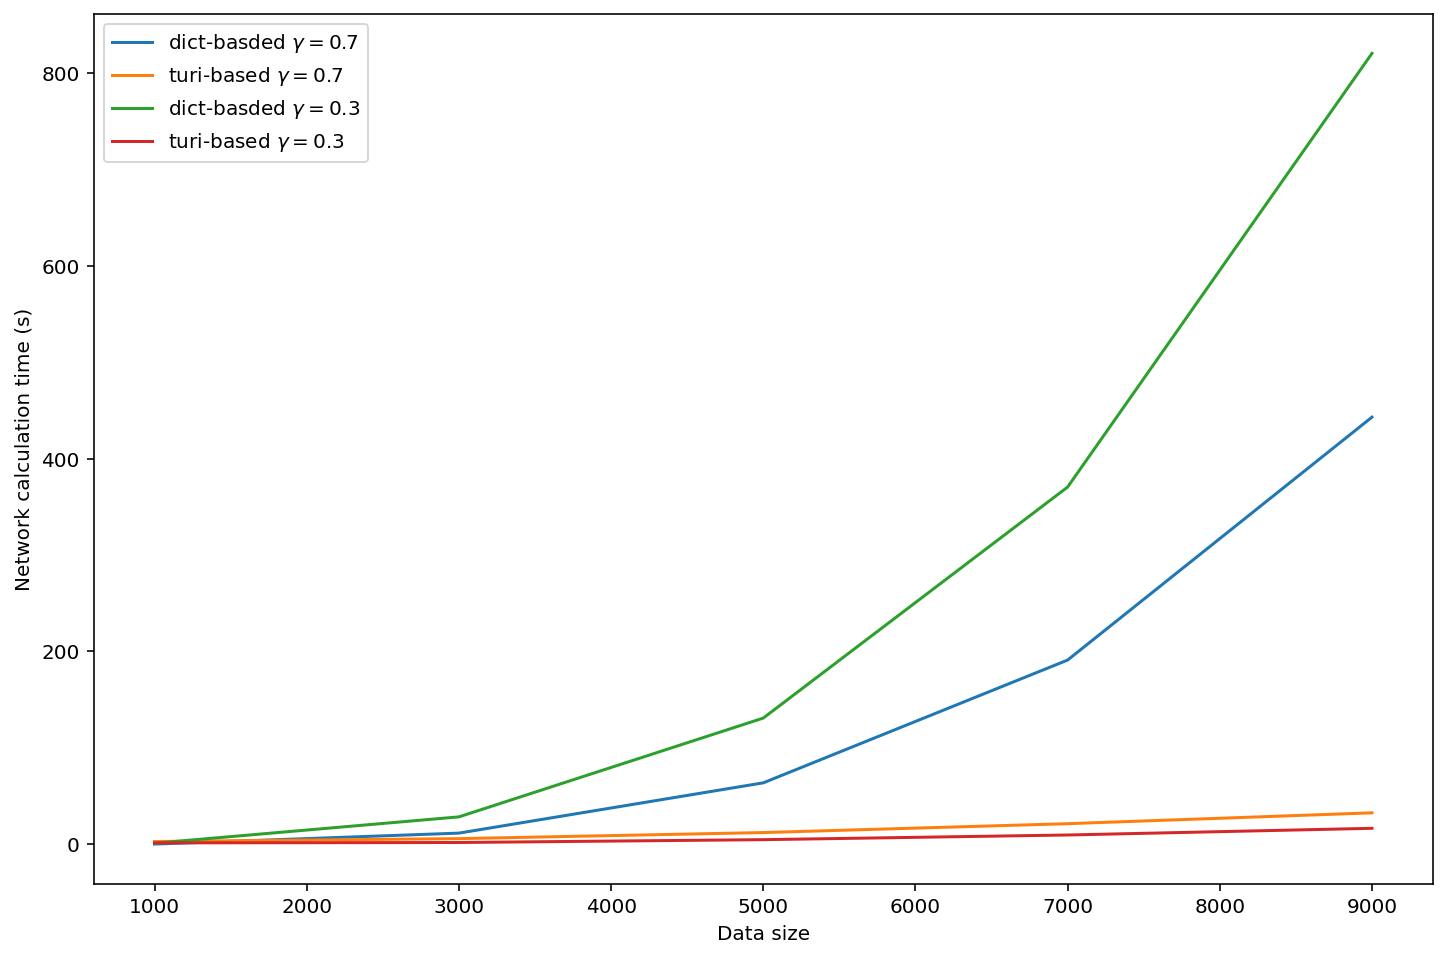

In [174]:
plt.figure(figsize=(12, 8))
plt.plot(df.dict, label='dict-basded $\gamma=0.7$')
plt.plot(df.tc, label='turi-based $\gamma=0.7$')

plt.plot(df3.dict, label='dict-basded $\gamma=0.3$')
plt.plot(df3.tc, label='turi-based $\gamma=0.3$')


plt.xlabel('Data size')
plt.ylabel('Network calculation time (s)')
plt.legend();

In [288]:
art = tc.SFrame(data=denorm(sms))

In [289]:
%time n2=f_create_network(data=art, gamma=.7)

CPU times: user 2min 29s, sys: 3.18 s, total: 2min 32s
Wall time: 48.3 s


In [292]:
len(n), len(n2), len(n3)

(8041, 8017, 8041)

In [293]:
sum(map(len, n.values())), sum(map(len, n2.values()))

(1959, 1983)

In [294]:
sum(map(len, n.values())) + len(n), sum(map(len, n2.values())) + len(n2)

(10000, 10000)

In [298]:
def dis(n):
    for k, vs in tqdm(n.items()):
        for v in vs:
            if (distance:=ja(sms[k], sms[v]))>.7:
                print(f"Missassigned node: {k} {v} {distance}")

In [299]:
dis(n2)

In [332]:
def internode_dis(n):
    kw = list(n.keys())

    for i, k in tqdm(enumerate(kw)):
        for k2 in kw[i+1:]:
            if (distance:=ja(sms[k], sms[k2]))<.7:
                    print(f"Missassigned node: {k} {k2} {distance}")
    

In [333]:
internode_dis(n2)

In [310]:
for k, vs in tqdm(n.items()):
    if k not in n2:
        print(f"{k} not present")
        continue
    vs2  = n2[k]
    if vs2 == vs:
        continue
    print(f"difference in nodes for {k}")
    

difference in nodes for 1
difference in nodes for 10
difference in nodes for 15
difference in nodes for 20
difference in nodes for 23
difference in nodes for 31
difference in nodes for 33
difference in nodes for 34
37 not present
difference in nodes for 40
difference in nodes for 43
difference in nodes for 46
difference in nodes for 65
difference in nodes for 71
difference in nodes for 77
difference in nodes for 83
difference in nodes for 90
difference in nodes for 94
difference in nodes for 104
difference in nodes for 105
difference in nodes for 108
109 not present
117 not present
difference in nodes for 127
difference in nodes for 146
difference in nodes for 147
difference in nodes for 150
177 not present
difference in nodes for 186
189 not present
difference in nodes for 199
difference in nodes for 231
237 not present
difference in nodes for 248
difference in nodes for 251
difference in nodes for 295
316 not present
317 not present
difference in nodes for 323
difference in nodes for

In [326]:
{k for k,v in n2.items() if 37 in v}

{4104}

In [328]:
n2[4104], 4104 in n[37]

([37, 1894, 7015, 3399, 1747], True)

In [4]:
## Vorting networks

In [35]:
def votes_from_list(li, classifier):
    classes = [classifier(a) for a in li]
    su = sum(classes)
    return len(classes)-su, su

from collections import defaultdict

def convert_to_voting(net, classifier):
    voting_network = defaultdict(lambda: [0, 0])

    for k, l in net.items():
        bi, mal = votes_from_list(l+[k], classifier)
        voting_network[k] = [bi, mal]

    return dict(voting_network)

In [18]:
labels = read_labels()

Got data:  27718


In [24]:
classifier = lambda x: int(labels.loc[x]['malware_label'])

In [35]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')
subsamp = get_sample(mw=mw, frac=0.1)

In [38]:
agg_net = f_create_network(data=mw, gamma=.7)

In [43]:
vn = convert_to_voting(net=agg_net, classifier=classifier)

In [44]:
vn

{'4C202C4FCE06E837C1526240C9648C08B3B9E1EC1CA41AD0D4862AF8FA304EDE': [225,
  1234],
 '43D5B9EDA4B958B076EE83FC05B5085769F3C58B9C2CE7BA5FE87B6B68C15DCB': [659, 0],
 'A6F33FEF1F0BE951236868202C42AF6E0BEC17D4FF7ECDC3CA5E6B95163BB450': [0, 123],
 '5B905D384E8E3024EFC408E82D7DEF32C517E105523EB5F433688E0525E98555': [218, 71],
 'E24913A89D488FB275B83A9AB67A21FB19E6D9B28EFD99A714421B771F06D7C3': [0, 7],
 'D02E53E37DCE813CF8D672A9405991839CECFC2EB1F58F056B4EA74548EDCB8A': [4, 111],
 '775B77E8D6EF1B9BE42C984A06B1CC7AA39F4F0AF3AB298EE806F92D219CE539': [0, 26],
 '2A818BBC6A53C867FD1E4CE224E5D3D1A3483F579BED36DFB98111521E1C28C1': [0, 24],
 'C2D97215FF83326123039AD7AA9183675B09598FFBCBE8D18D582D4B19682B18': [471,
  129],
 '715BC90606A97EB083DB19BF8BF20084317B885D78A4232C81ADF423D466F2CC': [12, 73],
 '1DE5BC2C00327C5A906DC0E56B5C0EB8A19A46A862C795DFE58418BA6BC5235D': [10, 108],
 'A90F7284D1EF0246D606D38975A4D09F208520852904B95213B65248BDD9D694': [235,
  353],
 '8E9BC77DA04B9404C86859861728627674CEB16

In [47]:
sum(map(sum, vn.values()))

10003

In [48]:
mw['apk'].unique().shape

(10003,)

In [210]:
def merge_voting_nets(nets, datas, gamma):
    dat = datas[0]
    for data in datas[1:]:
        dat = dat.append(data)

    nn = f_create_network(gamma=gamma,data=dat)
    
    # transfer the "votes" from original networks to just created new anchors
    targ = dict()
    for k, v in nn.items():
        for net in nets:
            if k in net:
                targ[k] = net.get(k)
                break

        for el in v:
            for net in nets:
                if el in net:
                    targ[k] = list(np.add(targ[k], net[el]))
                    break

    return targ

In [49]:
subsamp = get_sample(mw=mw, frac=0.1)

In [95]:
apks = subsamp['apk'].unique()

In [131]:
parts = apks.random_split(fraction=.5)

In [132]:
eses = [subsamp.filter_by(values=part, column_name='apk') for part in parts]

In [133]:
agg_nets = [f_create_network(data=s, gamma=.7) for s in eses]
vot_nets = [convert_to_voting(net=agg_net, classifier=classifier) for agg_net in agg_nets]

In [134]:
datas = [s.filter_by(values=vot_net.keys(), column_name='apk') for s, vot_net in zip(eses, vot_nets)]

In [135]:
# how many apks become anchors (and thus has to be passed to merger)
(datas[0].shape[0] + datas[1].shape[0]) / (s1.shape[0] + s2.shape[1])

0.6893468505093212

In [136]:
mgd = merge_voting_nets(nets=vot_nets, datas=datas, gamma=.7)

In [139]:
[sum(map(sum, x.values())) for x in [mgd]+vot_nets], sum([sum(map(sum, x.values())) for x in vot_nets])

([993, 471, 522], 993)

In [175]:
# Train/Test


In [177]:
from sklearn.model_selection import train_test_split

In [178]:
mw = tc.load_sframe('../binarydata/sample_10000_vt_mal_2017_2020_az_2020_benign_hashed_md5.sframe')

In [182]:
apks = mw['apk'].unique()

napks = apks.to_numpy()

In [183]:
test_size = 1000
train, test = train_test_split(napks, test_size=test_size, random_state=42)

In [226]:
np.save("/tmp/foo", test)

array(['A0D5BCB64C29789249E98FFE57A118A88F1CCE4ADC0D565310987F85F0C1BF6F',
       '4D564711364BF684948708202358D2703E9B609B026B6618725273DB29C99941',
       '040960013660BCFC375DCEFAFF6FF9171520109B31EBBAA8F9EEBDB07ABC168C',
       'FD03557325647520A0C0A3FECC8E051DE11CCE0FD3B090A6A4EE12038E4382E4',
       '3C9E7321B5C4738B0BC099B7153817A082DEDE0E9A8BFF840574870A953987E1',
       '0562CAC6A6AB8BE2E12E4444FA0F1D6CD129BE3A2BDA930F24C508E997D96300',
       'D824BDEBDBB483043C711D5972A1761CA2C2A0B71224CCC061BC412C07AEB234',
       'E401DA00510D6C86EC17F765A6138F824B653CF2DC3D71A57FCED20CD9D22D5E',
       '27E3A273C6BE786F375DEEC3A8CF413F31EB2F5AAC49E80F81C4FADB116A5C66',
       '0A62756F723E9F0AE8723CD042EC2B9BB6F2D6697D900770AD76CFAE262221A0',
       '1376E66BDA5E7359D7AAFA17E2C9B71790ADD167FD4340ABE1E16B4DDFD5E060',
       '269A2305D9DE7289E03AC1900CC84249AF5CE0DBEEF541AD4E2465F6D71D042A',
       'BE974F6E82AE88A1AF75B7C03C7EF30B7B8A41F20EB4E4DD0E474676B133058F',
       'B0BE331036F9F9D36

In [ ]:
## partition

In [195]:
from numpy.random import default_rng

def partition_ndframe(nd, n_parts):
    rn = default_rng(42)
    permuted_indices = rn.permutation(len(nd))

    dfs = []
    for i in range(n_parts):
        dfs.append(nd[permuted_indices[i::n_parts]])
    return dfs

In [200]:
subsamp = get_sample(mw=mw, frac=0.1)

In [204]:
napks = subsamp['apk'].unique().to_numpy()

parts = partition_ndframe(nd=napks, n_parts=4)

sparts = [subsamp.filter_by(values=part, column_name='apk') for part in parts]

In [206]:
agg_nets = [f_create_network(data=s, gamma=.7) for s in sparts]
vot_nets = [convert_to_voting(net=agg_net, classifier=classifier) for agg_net in agg_nets]

In [207]:
## marge

In [214]:
datas = [s.filter_by(values=vot_net.keys(), column_name='apk') for s, vot_net in zip(sparts, vot_nets)]

In [215]:
mgd = merge_voting_nets(nets=vot_nets, datas=datas, gamma=.7)

In [216]:
mgd

defaultdict(None,
            {'32D725650095CF9168AA1F1C4F2F907B2B84D827218F71DA3B14CF83F556A4DE': [67,
              176],
             '8D22A4638EBA1116AAA843012F18833619AFDB8415470D9E7DF1D8102608593B': [15,
              3],
             '783A8796BED45AB46981267C207FAC87FCACD58F44576D12152F64B9058C9E48': [6,
              0],
             '8EE812BCBA6C1071E215FDD689DC5D8AEEEC9C02CDE9384D076FD0181B9930E2': [33,
              0],
             'E142EE2969A7E6A32F9F51CDF26BA4A0A15210E4FEAF1791067B0E62942C3ACD': [34,
              52],
             'B7A7974CBE3CEF056934140A094F04B745E31C94ADDE61B3066A5FB4E9D56479': [0,
              12],
             'F0B1901C7D5BBA7D403C21B2DB9F269DCA0447EAE44CF03851C93BD28C78E3CB': [0,
              12],
             'CF208D43CB8C5B5243CD408424A1560181FB67CE94AC6B579951E9D2ECA5EE01': [21,
              0],
             '65CA4CC464EE6FB92205CD7D72B8B30912F8A80FC8BF4AC9235F08DF142F82E2': [41,
              2],
             'B3FF84EAECAF7936436B987DAD37C2

In [228]:
subsamp.remove_column?

In [231]:
def dist_and_net(data, gamma):
    net = f_create_network(data=data, gamma=gamma)
    return net, data.filter_by(values=net.keys(), column_name='apk')

In [237]:
net, data = dist_and_net(data=sparts[0], gamma=0.7)

In [238]:
data.shape, datas[0].shape

((357507, 3), (357507, 3))

In [239]:
len(net.keys()), len(agg_nets[0].keys())

(90, 90)

you allow some number of points from different classes at distance < gamma (effective alfa)
-> 


Tatiana: doubling dimension for the data set


Adj. graph in a readable format
-> to calculate the doubling dimension: number of anchors f(epsilon) 


-> unique apk form the recommender
-> perfomrance of single operations?

-> vertex cover: will give us insight into the optimality size of the network 
->(vertex cover np-complete, approx. result)

-> performance evaluation pipeline


In [249]:
apks = subsamp['apk'].unique()
funcs = subsamp['function'].unique()

In [251]:
apks

dtype: str
Rows: 993
['2D151F82FA37F7E52342909747348C7613905B6CDB82CB8005A38299F0D908EB', '3CF1AFC667C2DFB9349FE53224E443BA6D0E2A38497DD2292AC1493D3E27AA1F', 'EECF57216C9E1E16CDD4765F2A6243BE4D0961D5A5511E1E7ACF297690578746', 'BDF4F232B65D7028755E3C94B3B79365AD9B97105440CB5413D42363D3FF0D26', 'B912DECE1499F3F73D6133E177C798F46144F9F84CA4754EC904FF44A4FC3AB0', '20F80085F87783EBA4793E55647877CDBA9E93866D79EBD43A4C00CF975B716F', 'A768F52C886CB9758EFD473EF30A65CFBD3CF6B81109D8639FFE352C2227CE98', '5FE31B640C07C1EF1FC4BA618CD795A8DB44BB3B0575A44349DF68424ED570B8', '62DC51A642A9FBB733E5A987B7E44757119BF4E2653B5BA3E489D518D3C42DA9', '7D017638CF9B903D248221E03686E88C3FE51F651996AD5DBFE98D527F3419E6', '9819225E3B41245C9EA4A4D64B63F715D5A5FEBBA8547442A86F9B32A0CFD196', '252828EC2E6157F9E7EBFBE0794AE141079323B860AAF0A222CD2EBA43B9E595', '9D052620A36838B4283328A77F31B5B6A8F7DB9314CDA4CE8C65784280FB82D9', 'EE88097C249E5C90529A79271D3571D1FF2573AFD842DFC97F56230838D23B6C', '7142D3AF63CDD8A7094315A3A

In [252]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()

In [254]:
enc.fit(apks.to_numpy().reshape(-1, 1))

OrdinalEncoder()

In [257]:
r = enc.transform(apks.to_numpy().reshape(-1, 1)).astype(int)


In [259]:
r = enc.transform(subsamp['apk'].to_numpy().reshape(-1, 1)).astype(int)

In [266]:
res1  = subsamp.add_column(r, column_name='apki')



Finished parsing file /Users/jj/git/knnexp/data/functions_encoded.csv

Parsing completed. Parsed 100 lines in 1.19213 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 3636125 lines. Lines per second: 1.6142e+06

Read 32724913 lines. Lines per second: 4.32172e+06

Finished parsing file /Users/jj/git/knnexp/data/functions_encoded.csv

Parsing completed. Parsed 35170194 lines in 7.81821 secs.

In [281]:
r1 = tc.SFrame.read_csv('../data/functions_encoded.csv')
r1=r1.rename(names={'apn': 'apk', 'nf': 'function', 'usage': 'fcount'})
r1.save('../binarydata/funcs-encoded', format='binary')

In [283]:
mwx = tc.load_sframe('../binarydata/funcs-encoded')
mwx.head()

apk,function,fcount
5868,124151,1
38,205926,1
3965,412019,2
4227,455698,1
8365,89728,1
16611,673605,1
17213,507119,1
33,204076,1
497,342467,1
8526,204076,1


In [284]:

nn = f_create_network(data=mwx, gamma=0.7)

In [278]:
mw.column_names()

['fcount', 'apk', 'function']

In [291]:
labels = pd.read_csv('../data/labels_encoded.csv', index_col=0)

In [292]:
classifier = lambda x: int(labels.loc[x]['malware_label'])


In [293]:
mwx[0]

{'apk': 5868, 'function': 124151, 'fcount': 1}

In [296]:
classifier(9898)

1

In [297]:
convert_to_voting(net=nn, classifier=classifier)

{0: [0, 19],
 2: [12, 7],
 3: [282, 1274],
 6: [427, 95],
 16384: [658, 0],
 16386: [0, 58],
 16389: [634, 483],
 10: [176, 0],
 11: [156, 0],
 14: [52, 0],
 15: [42, 6],
 16399: [0, 10],
 18: [45, 0],
 21: [18, 0],
 16406: [178, 6],
 24: [0, 6],
 16411: [288, 0],
 28: [31, 0],
 16414: [5, 109],
 33: [1, 4],
 35: [0, 55],
 16426: [7, 1],
 48: [0, 28],
 55: [0, 2],
 16447: [187, 0],
 16449: [0, 53],
 73: [39, 0],
 16461: [65, 4],
 82: [25, 177],
 84: [0, 5],
 24576: [0, 123],
 8203: [15, 4],
 24595: [7, 63],
 8232: [182, 0],
 8233: [18, 0],
 8241: [1, 6],
 24626: [0, 108],
 24629: [0, 12],
 8250: [0, 46],
 24641: [3, 11],
 8258: [0, 9],
 8259: [7, 81],
 8264: [5, 0],
 8265: [7, 9],
 24657: [0, 10],
 8275: [23, 0],
 24659: [0, 81],
 16470: [14, 15],
 16474: [59, 4],
 24666: [4, 57],
 24671: [14, 15],
 96: [0, 12],
 8289: [7, 4],
 98: [0, 23],
 24675: [0, 2],
 16485: [0, 18],
 24677: [0, 25],
 102: [0, 9],
 16486: [31, 2],
 16491: [2, 0],
 16492: [57, 1],
 8301: [16, 0],
 115: [0, 2],
 24

In [2]:
## eval


In [19]:
test_apns = np.load('../res/test-tc-1000.npy')

In [6]:
import pickle

net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [10]:
gam = 0.3888888888888889

In [11]:
[mer, ref]= nets[gam]

In [14]:
labels = pd.read_csv('../data/labels_encoded.csv', index_col=0)
mwx = tc.load_sframe('../binarydata/funcs-encoded')

In [16]:
apks = mwx['apk'].unique()

In [22]:
def compare_apk_sets(a, b):
    return [ap for ap in a if ap not in b]

In [23]:
compare_apk_sets(ref.keys(), apks)

[]

In [29]:
classifier = lambda x: int(labels.loc[x]['malware_label'])

In [30]:
classifier(ref[0][0])

1

In [36]:
ref_vot = convert_to_voting(ref, classifier)

In [38]:
nc = dict()
for gamma, [mer, ref] in nets.items():
    ref_vot = convert_to_voting(ref, classifier)
    nc[gamma] = [mer, ref_vot]
    
with open(f"9003-tc-jaccard-votingnets.pickle", 'wb+') as f:
    pickle.dump(nets, f)